<a href="https://colab.research.google.com/github/Mvideoo/Vzlet_robot/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22transfer_learning_tutorial_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.6 MB/s eta 0:00:00


In [2]:
!unzip руды.zip

Archive:  руды.zip
   creating: руды/
   creating: руды/train/
   creating: руды/train/алюминий/
  inflating: руды/train/алюминий/0.016157544776741695.jpg  
  inflating: руды/train/алюминий/0.01690569550789489.jpg  
  inflating: руды/train/алюминий/0.03807908086579581.jpg  
  inflating: руды/train/алюминий/0.04176122691687911.jpg  
  inflating: руды/train/алюминий/0.06507594189159793.jpg  
  inflating: руды/train/алюминий/0.09390450671039308.jpg  
  inflating: руды/train/алюминий/0.10851258665507602.jpg  
  inflating: руды/train/алюминий/0.11292876767294413.jpg  
  inflating: руды/train/алюминий/0.12176135042600689.jpg  
  inflating: руды/train/алюминий/0.1360342052414677.jpg  
  inflating: руды/train/алюминий/0.1374039742223655.jpg  
  inflating: руды/train/алюминий/0.14460985812658889.jpg  
  inflating: руды/train/алюминий/0.1618824565322945.jpg  
  inflating: руды/train/алюминий/0.16599194583586308.jpg  
  inflating: руды/train/алюминий/0.2478424440249528.jpg  
  inflating: руды/tra

In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import torch.nn.functional as F

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/руды'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



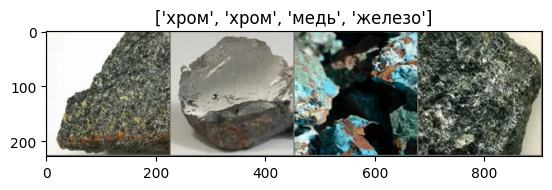

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} ground truth {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))


num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 8)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.6MB/s]


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=28)

Epoch 0/27
----------
train Loss: 1.8927 Acc: 0.3091
val Loss: 1.7730 Acc: 0.3922

Epoch 1/27
----------
train Loss: 1.7005 Acc: 0.4239
val Loss: 2.0306 Acc: 0.3595

Epoch 2/27
----------
train Loss: 1.6426 Acc: 0.4644
val Loss: 1.6886 Acc: 0.5033

Epoch 3/27
----------
train Loss: 1.6305 Acc: 0.4498
val Loss: 1.6230 Acc: 0.4902

Epoch 4/27
----------
train Loss: 1.5800 Acc: 0.4741
val Loss: 1.5741 Acc: 0.4771

Epoch 5/27
----------
train Loss: 1.5164 Acc: 0.4725
val Loss: 1.5513 Acc: 0.5229

Epoch 6/27
----------
train Loss: 1.5502 Acc: 0.4676
val Loss: 1.9793 Acc: 0.5098

Epoch 7/27
----------
train Loss: 1.2943 Acc: 0.5631
val Loss: 1.2997 Acc: 0.6078

Epoch 8/27
----------
train Loss: 1.0933 Acc: 0.6133
val Loss: 1.3331 Acc: 0.5948

Epoch 9/27
----------
train Loss: 1.0573 Acc: 0.6294
val Loss: 1.2689 Acc: 0.6209

Epoch 10/27
----------
train Loss: 1.0503 Acc: 0.6392
val Loss: 1.2975 Acc: 0.6405

Epoch 11/27
----------
train Loss: 1.0701 Acc: 0.6424
val Loss: 1.2825 Acc: 0.5882

Ep

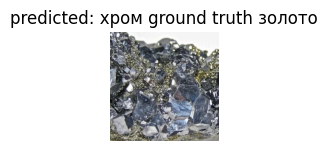

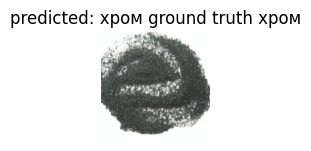

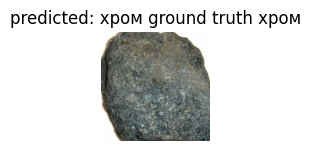

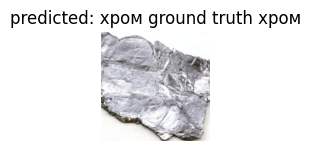

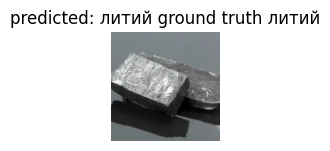

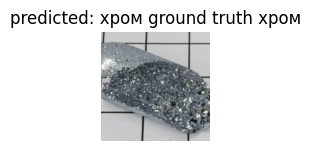

In [11]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.



In [16]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model_ft.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 8)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=14)

Epoch 0/13
----------
train Loss: 2.0052 Acc: 0.2670
val Loss: 2.0934 Acc: 0.2876

Epoch 1/13
----------
train Loss: 1.7619 Acc: 0.3786
val Loss: 1.8136 Acc: 0.3791

Epoch 2/13
----------
train Loss: 1.6195 Acc: 0.4191
val Loss: 1.6554 Acc: 0.4314

Epoch 3/13
----------
train Loss: 1.5655 Acc: 0.4434
val Loss: 1.5443 Acc: 0.4248

Epoch 4/13
----------
train Loss: 1.5488 Acc: 0.4644
val Loss: 1.4736 Acc: 0.5490

Epoch 5/13
----------
train Loss: 1.5194 Acc: 0.4741
val Loss: 1.5511 Acc: 0.5425

Epoch 6/13
----------
train Loss: 1.5677 Acc: 0.4757
val Loss: 1.4248 Acc: 0.5490

Epoch 7/13
----------
train Loss: 1.3457 Acc: 0.5259
val Loss: 1.3729 Acc: 0.5490

Epoch 8/13
----------
train Loss: 1.3165 Acc: 0.5340
val Loss: 1.3764 Acc: 0.5490

Epoch 9/13
----------
train Loss: 1.3614 Acc: 0.5405
val Loss: 1.4097 Acc: 0.5490

Epoch 10/13
----------
train Loss: 1.2958 Acc: 0.5372
val Loss: 1.3968 Acc: 0.5163

Epoch 11/13
----------
train Loss: 1.3016 Acc: 0.5599
val Loss: 1.4350 Acc: 0.5294

Ep

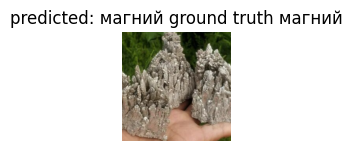

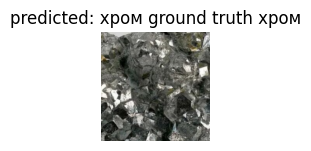

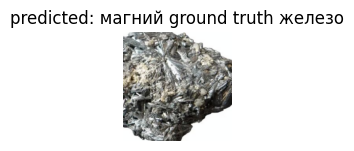

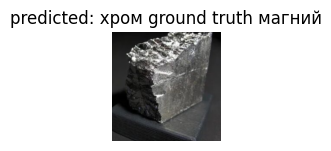

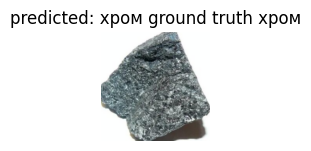

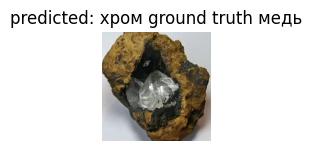

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()


## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [146]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

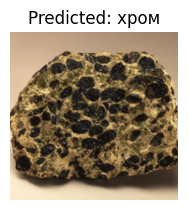

In [148]:
visualize_model_predictions(
    model_conv,
    img_path='/content/хром.webp'
)

plt.ioff()
plt.show()

In [ ]:
from torch import tensor
target = tensor([0, 1, 2, 3])
preds = tensor([0, 2, 1, 3])
accuracy = Accuracy(task="multiclass", num_classes=4)
accuracy(preds, target)
